In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets
channel_spend = pd.read_csv('Creditor(watch) - Channel Spend By Month.csv')
leads = pd.read_csv('Creditor(watch) - Leads (2).csv')
sales = pd.read_csv('Creditor(watch) - Sales.csv')

Cleaning and Transforming Channel_Soend Dataset

In [3]:
# Clean the channel spend data
channel_spend = channel_spend.replace({'\$': '', ',': '', '-': '0'}, regex=True)
for col in channel_spend.columns[1:]:
    channel_spend[col] = pd.to_numeric(channel_spend[col].astype(str).str.strip())

# Add the year to the month and convert to datetime
channel_spend_melted = channel_spend.melt(id_vars=["Channel"], var_name="Month", value_name="Spend")
channel_spend_melted['Month'] = pd.to_datetime(channel_spend_melted['Month'] + '-2023', format='%d-%b-%Y')

channel_spend_melted.head()

,Channel,Month,Spend
0,Social,2023-01-01,1000
1,Paid Search,2023-01-01,5000
2,Display,2023-01-01,2500
3,Event,2023-01-01,0
4,Social,2023-02-01,1000


Cleaning and Transforming Leads and Sales Data

In [4]:
# Clean leads and sales data
leads['Date'] = pd.to_datetime(leads['Date'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
leads['Month'] = pd.to_datetime(leads['Month'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
sales['Date'] = pd.to_datetime(sales['Date'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
sales['Month'] = pd.to_datetime(sales['Month'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
sales['Sale Amount'] = sales['Sale Amount'].replace({'\$': '', ',': ''}, regex=True).astype(float)


In [5]:
# Merge leads and sales data to attribute sales to channels
merged_data = leads.merge(sales, on=['Company ID', 'Month'], suffixes=('_lead', '_sale'))

# Distribute sales amount evenly across all leads for each company
merged_data['Sale Amount'] = merged_data['Sale Amount'] / merged_data.groupby('Company ID')['Company ID'].transform('count')


Monthly Metrics

In [6]:
# Convert 'Month' columns back to datetime for grouping
channel_spend_melted['Month'] = pd.to_datetime(channel_spend_melted['Month'], format='%d/%m/%Y')
leads['Month'] = pd.to_datetime(leads['Month'], format='%d/%m/%Y')
merged_data['Month'] = pd.to_datetime(merged_data['Month'], format='%d/%m/%Y')

# Aggregate monthly spend per channel
monthly_spend_per_channel = channel_spend_melted.groupby(['Channel', 'Month'])['Spend'].sum().reset_index()

# Aggregate monthly leads per channel
monthly_leads_per_channel = leads.groupby(['Channel', 'Month']).size().reset_index(name='Total Leads')

# Aggregate monthly revenue per channel after distributing sales amount
monthly_revenue_per_channel = merged_data.groupby(['Channel', 'Month'])['Sale Amount'].sum().reset_index()
monthly_revenue_per_channel.columns = ['Channel', 'Month', 'Total Revenue']

# Aggregate monthly sales per channel after distributing sales amount
monthly_sales_per_channel = merged_data.groupby(['Channel', 'Month'])['Sale Amount'].count().reset_index()
monthly_sales_per_channel.columns = ['Channel', 'Month', 'Total Sales']


In [7]:
# Calculate monthly CPL
monthly_cpl = monthly_spend_per_channel.merge(monthly_leads_per_channel, on=['Channel', 'Month'])
monthly_cpl['CPL'] = monthly_cpl['Spend'] / monthly_cpl['Total Leads']

# Calculate monthly CPA
monthly_cpa = monthly_spend_per_channel.merge(monthly_sales_per_channel, on=['Channel', 'Month'])
monthly_cpa['CPA'] = monthly_cpa['Spend'] / monthly_cpa['Total Sales']

# Calculate monthly ROI
monthly_roi = monthly_spend_per_channel.merge(monthly_revenue_per_channel, on=['Channel', 'Month'])
monthly_roi['ROI'] = (monthly_roi['Total Revenue'] - monthly_roi['Spend']) / monthly_roi['Spend']



Visualisation 

In [8]:
# Define a custom color palette
palette = {
    "Social": "#3399cc",
    "Paid Search": "#ffa64d",
    "Display": "#4db84d",
    "Event": "#ff4d4d"
}


In [9]:
# Convert 'Month' to datetime and format it
channel_spend_melted['Month'] = pd.to_datetime(channel_spend_melted['Month']).dt.strftime('%d/%m/%Y')

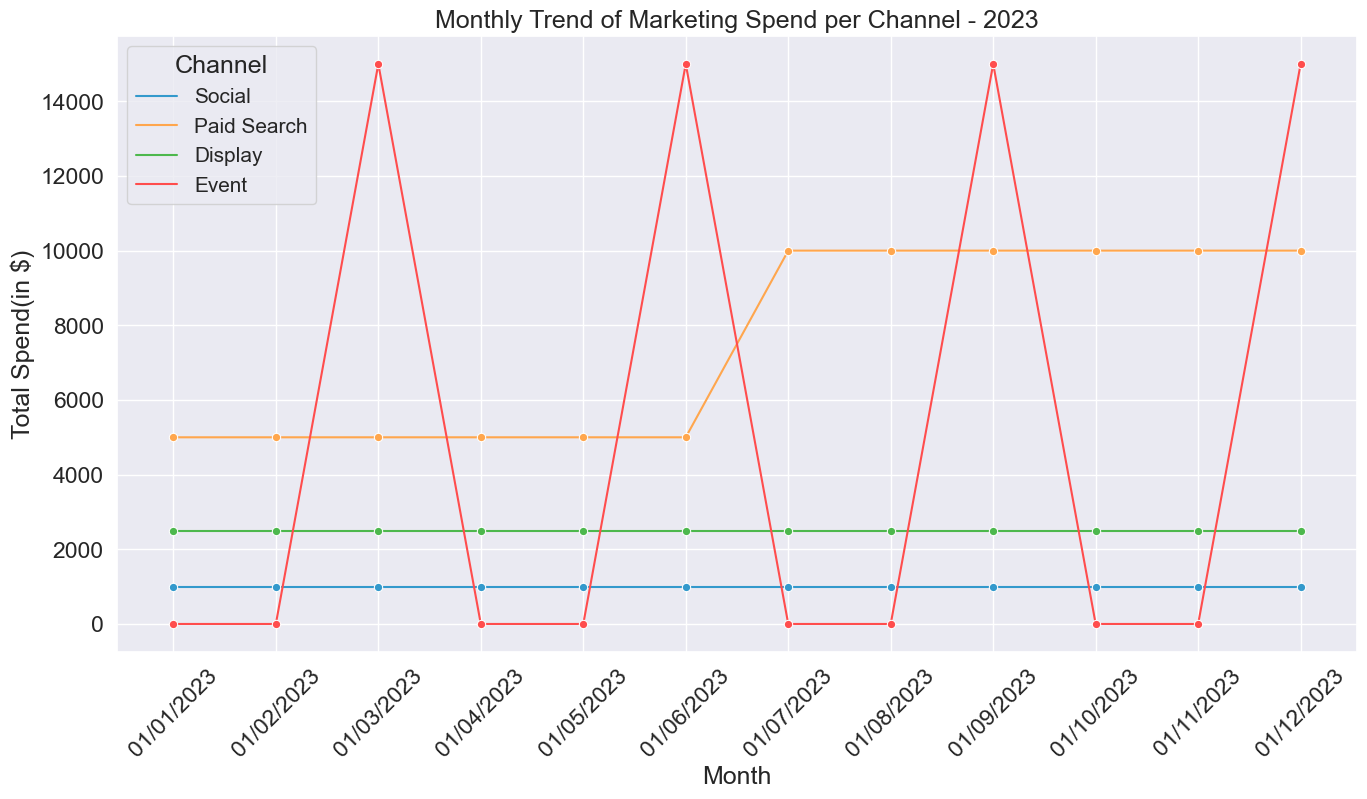

In [10]:

# Visualization 1: Month-on-Month Marketing Spend per Channel
sns.set(font_scale=1.5)
plt.figure(figsize=(16, 8))
sns.lineplot(data=channel_spend_melted, x='Month', y='Spend', hue='Channel', marker='o', palette=palette)
plt.title('Monthly Trend of Marketing Spend per Channel - 2023')
plt.xlabel('Month')
plt.ylabel('Total Spend(in $)')
plt.xticks(rotation=45)
plt.legend(title='Channel', fontsize='small')  # Reduce legend size

plt.show()


In [11]:
# Convert 'Month' to datetime and format it for monthly_cpl if not already done
monthly_cpl['Month'] = pd.to_datetime(monthly_cpl['Month']).dt.strftime('%d/%m/%Y')

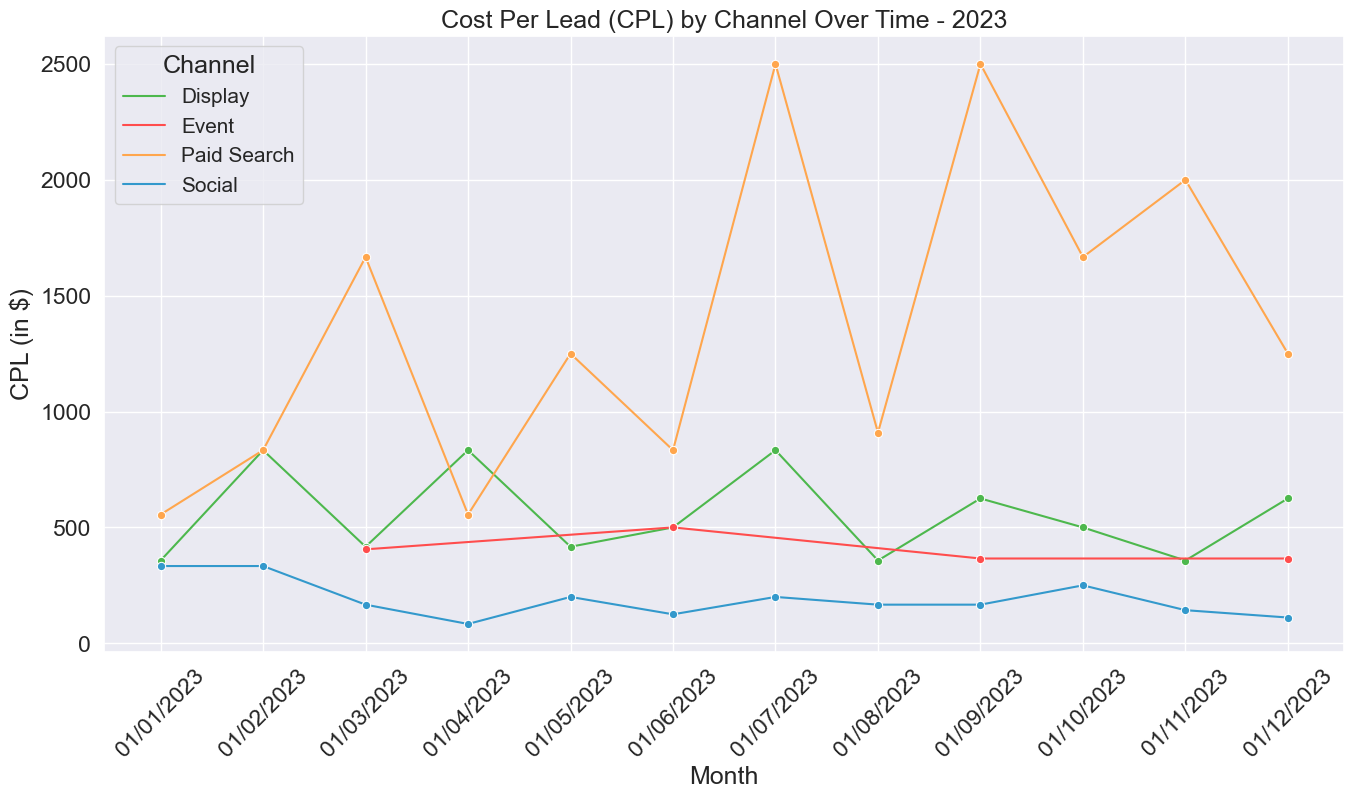

In [12]:
# Set up the visualizations
sns.set(font_scale=1.5)

# Cost Per Lead (CPL) Visualization
plt.figure(figsize=(16, 8))
sns.lineplot(data=monthly_cpl, x='Month', y='CPL', hue='Channel', marker='o', palette=palette)
plt.title('Cost Per Lead (CPL) by Channel Over Time - 2023',weight='bold')
plt.xlabel('Month')
plt.ylabel('CPL (in $)')
plt.xticks(rotation=45)
plt.legend(title='Channel', fontsize='small')  # Reduce legend size

plt.show()

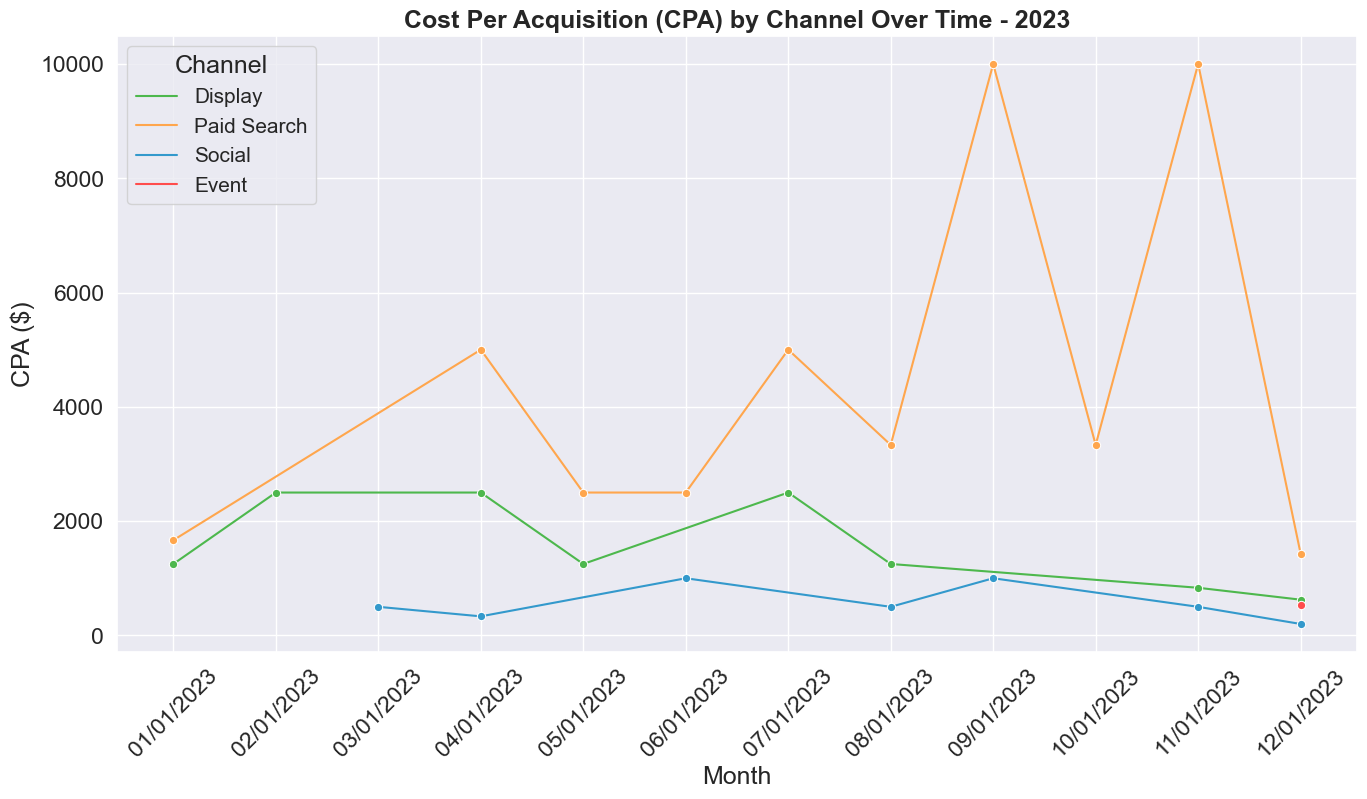

In [18]:
# Ensure 'Month' is in datetime format
monthly_cpa['Month'] = pd.to_datetime(monthly_cpa['Month'])

# Sort by Month to ensure chronological order
monthly_cpa = monthly_cpa.sort_values(by='Month')

# Convert 'Month' back to dd/mm/yyyy format for display
monthly_cpa['Month'] = monthly_cpa['Month'].dt.strftime('%d/%m/%Y')

# Cost Per Acquisition (CPA) Visualization
sns.set(font_scale=1.5)

plt.figure(figsize=(16, 8))
sns.lineplot(data=monthly_cpa, x='Month', y='CPA', hue='Channel', marker='o', palette=palette)
plt.title('Cost Per Acquisition (CPA) by Channel Over Time - 2023', weight='bold')
plt.xlabel('Month')
plt.ylabel('CPA ($)')
plt.xticks(rotation=45)
plt.legend(title='Channel', fontsize='small')  # Reduce legend size

plt.show()


In [15]:
# Convert 'Month' to datetime and format it for monthly_roi if not already done
monthly_roi['Month'] = pd.to_datetime(monthly_roi['Month']).dt.strftime('%d/%m/%Y')

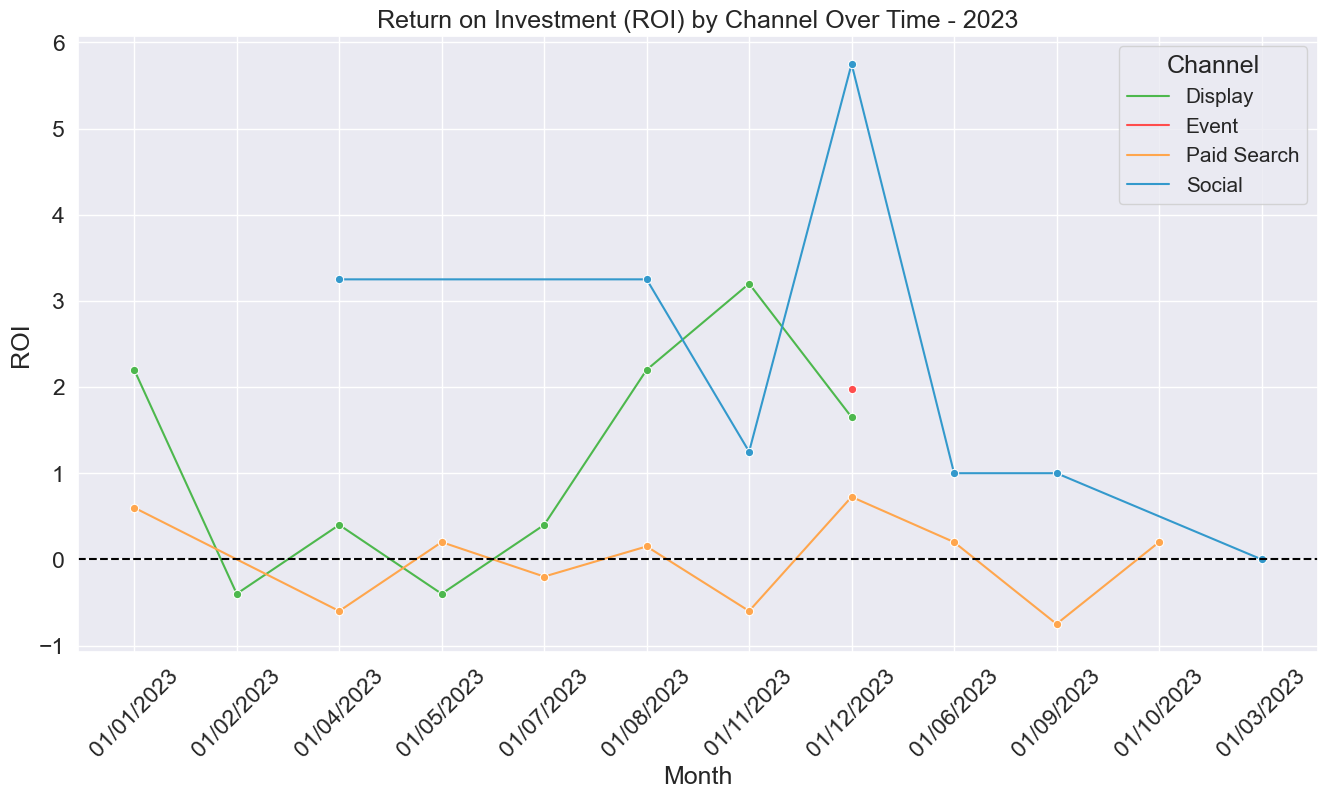

In [16]:
# Set up the visualizations
sns.set(font_scale=1.5)

# Return on Investment (ROI) Visualization with trend lines
plt.figure(figsize=(16, 8))
sns.lineplot(data=monthly_roi, x='Month', y='ROI', hue='Channel', marker='o', palette=palette)
plt.axhline(0, color='black', linestyle='--')  # Add a horizontal line at y=0 to indicate 0 ROI
plt.title('Return on Investment (ROI) by Channel Over Time - 2023',weight='bold')
plt.xlabel('Month')
plt.ylabel('ROI')
plt.xticks(rotation=45)
plt.legend(title='Channel', fontsize='small')  # Reduce legend size

plt.show()